# NN Prediction
The title of the notebook should be coherent with file name. Namely, file name should be:

## Purpose
Explore the use of Neural Networks for the prediction of seismic events.

## Methodology
Quickly describe assumptions and processing steps.

## Results
Describe and comment the most important results.

## Setup

To create a new environment with all the necessary requirements use:
<br><br>
<code>
$ conda create --name <env> --file requirements.txt
</code>


### Library import
We import all the required Python libraries

In [ ]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython import get_ipython
from matplotlib import cm
from sklearn.model_selection import train_test_split
#from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

pdf = pd.DataFrame

% matplotlib qt
from sklearn.metrics import confusion_matrix

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    % load_ext autoreload

% autoreload 2

UsageError: Line magic function `%` not found.


### Local library import
We import all the required local libraries

In [2]:
import model
from model import CalculateFeatures, SelectFeatures, REGION

## Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the other variables follow Python's guidelines.

In [3]:
USE_CACHED_FEATURES = True
MAGNITUDE_THRESHOLD = 6.0
WINDOW_SIZE = 100

## Data import
We retrieve all the required data for the analysis.

In [11]:
print("Calculating new features...")
df = model.load_data('../../data/DATA_2.csv')
df = df[(df.Longitude > REGION.SOUTH.x1) & (df.Latitude < REGION.SOUTH.y1) &
        (df.Longitude < REGION.SOUTH.x2) & (df.Latitude > REGION.SOUTH.y2)]
df = df[(df.Datetime.dt.year >= 2017) & (df.Magnitude >= 3.8)]
df.reset_index(inplace=True,drop=True)
df_model = CalculateFeatures(df[0:250], WINDOW_SIZE, trim_features=True, mag_threshold=MAGNITUDE_THRESHOLD)
print("New features generated.")
features = df_model.features

Calculating new features...
151
Int64Index([ 37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
            ...
            141, 142, 143, 144, 145, 146, 147, 148, 149, 150],
           dtype='int64', length=114)
New features generated.


In [12]:
features

,old_index,firstT,lastT,elapsedT,meanMag,maxMag,rateSqrtEnergy,u,c,a_lsq,...,bStd_mlk,grcStd_lsq,grcStd_mlk,pMag_lsq,pMag_mlk,zSeismicRateChange,bSeismicRateChange,lastDMaxMag,nextDMaxMag,nextDMaxMagT
0,100,2017-01-01 04:10:39,2017-01-10 22:38:50,844091,3.946,4.8,92075.202925,8526.171717,1.483639e+09,9.599054,...,0.282674,24.493091,57.240580,8.191637e-13,1.419978e-18,338.082830,-12.370862,4.8,5.0,False
1,101,2017-01-01 04:23:51,2017-01-11 07:11:14,874043,3.945,4.8,88798.660386,8828.717172,1.483648e+09,9.586421,...,0.287058,24.419461,58.039053,8.514356e-13,1.069532e-18,1730.664612,324.335307,4.8,5.0,False
2,102,2017-01-01 04:26:01,2017-01-11 10:59:38,887617,3.945,4.8,87440.695164,8965.828283,1.483656e+09,9.586421,...,0.287058,24.419461,58.039053,8.514356e-13,1.069532e-18,1165.075105,144.459921,4.8,5.0,False
3,103,2017-01-01 08:49:23,2017-01-11 12:47:04,878261,3.947,4.8,88686.124601,8871.323232,1.483665e+09,9.622466,...,0.278383,24.614330,56.436180,7.661324e-13,1.877996e-18,967.264183,-98.818756,4.8,5.0,False
4,104,2017-01-01 09:14:06,2017-01-11 15:54:26,888020,3.945,4.8,87401.012950,8969.898990,1.483674e+09,9.586421,...,0.287058,24.419461,58.039053,8.514356e-13,1.069532e-18,987.876511,103.611734,4.8,5.0,False
5,105,2017-01-01 10:04:19,2017-01-12 08:10:45,943586,3.946,4.8,82366.472279,9531.171717,1.483683e+09,9.599054,...,0.282674,24.493091,57.240580,8.191637e-13,1.419978e-18,2357.244154,586.546687,4.8,5.1,False
6,106,2017-01-01 10:35:50,2017-01-12 10:26:58,949868,3.952,5.0,84855.782952,9594.626263,1.483693e+09,8.083138,...,0.325266,17.814841,59.664758,1.415140e-10,7.191124e-18,792.590689,64.347575,4.8,5.1,False
7,107,2017-01-01 12:20:19,2017-01-12 11:26:59,947200,3.955,5.0,85497.796022,9567.676768,1.483702e+09,8.124778,...,0.311496,18.020847,57.352299,1.254168e-10,1.543834e-17,516.526863,-27.239526,5.0,5.1,False
8,108,2017-01-01 12:32:57,2017-01-12 14:33:15,957618,3.960,5.0,85372.969701,9672.909091,1.483712e+09,8.188260,...,0.290307,18.285963,53.727069,1.060876e-10,5.175555e-17,1020.686044,106.507251,5.0,5.1,False
9,109,2017-01-01 12:53:06,2017-01-12 14:51:02,957476,3.961,5.0,85496.341518,9671.474747,1.483721e+09,8.197775,...,0.286313,18.336025,53.059589,1.031175e-10,6.532997e-17,119.163753,-1.443882,5.0,5.1,False


In [11]:
    # delete cached features to generate new features

if model.features_in_cache() and USE_CACHED_FEATURES:
    print("loading cached features...")
    features = model.load_features_from_cache()
    print("done.")
else:
    print("Calculating new features...")
    df = model.load_data('../../data/DATA_2.csv')
    df = df[(df.Longitude > REGION.SOUTH.x1) & (df.Latitude < REGION.SOUTH.y1) &
            (df.Longitude < REGION.SOUTH.x2) & (df.Latitude > REGION.SOUTH.y2)]
    df = df[(df.Datetime.dt.year >= 2017) & (df.Magnitude >= 3.8)]
    df_model = CalculateFeatures(df, WINDOW_SIZE, trim_features=True, mag_threshold=MAGNITUDE_THRESHOLD)
    print("New features generated.")
    features = df_model.features
    features.to_csv("../../model/features_cache/features.csv", index=False)
    print("New features saved.")

loading cached features...
done.


## Data processing

###  Feature selection

The features' data consist of 16 features, and there are two targets, only one is use on this

#### Features:
minimize


| Code |  Expression | Description |
| --- |  --- | --- |
|firstT | $T_{1}$   | First date.|
|lastT | $T_{n-1}$  | Last date.|
|meanMag | $M_{mean}=\dfrac{\sum_{i=1}^{n}( M_{i} )}{n}$  | Mean magnitude.|
|maxMag | $M_{max} = max(M)  $ | Max actual magnitude.|
|maxEMag | $M_{expected\;max} = \dfrac{a}{b}$ |Max expected magnitude.|
|a | ${\hat{\boldsymbol {\beta }}\in \operatorname {argmin} \limits _{\boldsymbol {\beta }}\sum _{i=1}^{n^{*}}\left[N_{i}-f\left(M^{*}_{i},{\boldsymbol {\beta }}\right)\right]^{2}}$<br> where <br> $f(M^{*},{\boldsymbol {\beta }})=10^{{\boldsymbol {\beta }_{1}-{\beta }_{2}M^{*}}}$<br>$M^{*}=$ unique elements of $M$ <br> $N=$ cardinality of each $M^{*}$<br><br> $a=\hat{{\boldsymbol {\beta }}_{1}}$| Levenberg–Marquardt algorithm, is used to solve a  of Gutenberg-Richter curve.|
|b | $b=\hat{{\boldsymbol {\beta }}_{2}}$ | Levenberg–Marquardt algorithm, is used to solve b slope of Gutenberg-Richter curve.|
|bStd | $σb = 2.3b\sqrt{\dfrac{\sum_{i=1}^{n}(M_{i}-M_{mean})^2}{n(n-1)}}$ | Standard deviation of b value.|
|grcStd | $\eta = \dfrac{\sum_{i=1}^{n}(M_{i}-M_{mean})^2}{n(n-1)}$ | Mean square deviation.|
|elapsedT | $\Delta T = T_{n-1} - T_{1}$  | Time elapsed of the last 'n' seismic events.|
|rateSqrtEnergy | $dE½ = \dfrac{\sum_{i=1}^{n}(10^{(11.8+1.5M_{i}})^{1/2}}{\Delta T}$ |Rate of square root of energy.|
|meanT | $\mu =\dfrac{\sum_{i=1}^{n}(\Delta T_{i} )}{n}$  | Mean of the differences of the times of each event.|
|meanTStd | $c = \sqrt{\dfrac{\sum_{i=1}^{n}(\Delta T_i- \mu )^2}{n-1}}$  | Standard Deviation of the differences of the times of each event.|
|magDef | $ΔM = M_{max} - M_{expected\;max} $  |Magnitude deficit.|
|zSeismicRateChange| $ z = \dfrac{N_{a}\Delta T_{b}-N_{b}\Delta T_{a}}{\sqrt{N_{a}\Delta T_{b}^2+N_{b}\Delta T_{a}^2}} $ <br> where<br> $N_{a}$ and $T_{a}$ are from the current window <br> $N_{b}$ and $T_{b}$ are from the next window| Seismic rate change proposed by Habermann and Wyss.|
|bSeismicRateChange| $β= \dfrac{N_a- \Lambda }{\sqrt{\Lambda }}$ <br> where <br> $\Lambda = N_{b}\times \dfrac{\Delta T_{a}}{\Delta T_{b}}$ | Seismic rate change proposed by Matthews and Reasenberg.|
|lastDMaxMag | $x6 = max\{M\}$, when $T \in{[T_{n-1}-d_{b}, T_{n-1})}$<br> where <br> $d_{b} =$ days to look behind | Max magnitude in the last d days.|
|pTMag[mag] | $x7 = 10^{-bm}$  | Probability of an earthquake equal or greater than a magnitude m. |

#### Targets:

| Code |  Expression | Description|
| --- | --- | --- |
|nextDMaxMag |  $y_{2} = max\{M\}$, when $T \in{[T_{n-1}, T_{n-1}+d_{a})}$  <br> where <br> $d_{a} =$ days to look ahead |  Max magnitude in the next $d_{a}$ days ahead .|
|nextDMaxMagT | $y_{2} = \begin{cases} 1 & \text{if } m >= M_{i}\\ 0& \text{if } m < M_{i}    \end{cases}$ |  Binary form of nextDMaxMag based on a [mag] threshold.|
|tTMag | $Te$|  Time-to-event in days of an earthquake equal or greater than [mag] !todo.|

$$y_{2} = max\{M\}$$
when
$$T \in{[T_{n-1}, T_{n-1}+d_{a})}$$
where
$$d_{a} =$$

In [5]:
model.FEATURES

['elapsedT',
 'meanMag',
 'maxMag',
 'rateSqrtEnergy',
 'u',
 'c',
 'a_lsq',
 'a_mlk',
 'b_lsq',
 'b_mlk',
 'maxEMag_lsq',
 'maxEMag_mlk',
 'magDef_lsq',
 'mag_def_mlk',
 'bStd_lsq',
 'bStd_mlk',
 'grcStd_lsq',
 'grcStd_mlk',
 'pMag_lsq',
 'pMag_mlk',
 'zSeismicRateChange',
 'bSeismicRateChange',
 'lastDMaxMag']

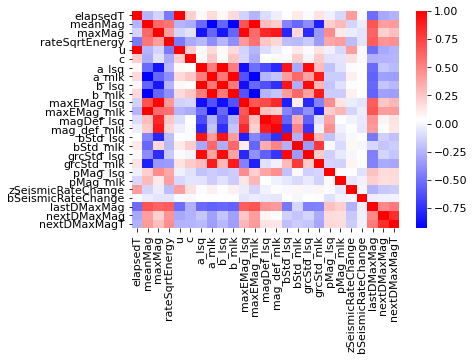

In [6]:
% matplotlib inline
plt.rcParams.update({'font.size': 11})
X = features[model.FEATURES]
Y_CONTINUOUS = features[model.TARGETS.CONTINUOUS]
Y_CATEGORICAL = features[model.TARGETS.CATEGORICAL]
selected_features = SelectFeatures(features=X, targets=Y_CONTINUOUS, corr_threshold=.99)
X = X.to_numpy()
Y_CONTINUOUS = Y_CONTINUOUS.to_numpy()
Y_CATEGORICAL = Y_CATEGORICAL.to_numpy()
corrMatrix = features[model.ALL_FEATURES].corr()
sns.heatmap(corrMatrix, yticklabels=corrMatrix.columns, xticklabels=corrMatrix.columns, cmap="bwr")
plt.show()

In [7]:
selected_features[0]

['lastDMaxMag',
 'bStd_mlk',
 'c',
 'pMag_mlk',
 'zSeismicRateChange',
 'rateSqrtEnergy',
 'bSeismicRateChange',
 'pMag_lsq',
 'u',
 'maxEMag_mlk',
 'grcStd_lsq',
 'magDef_lsq',
 'grcStd_mlk',
 'maxEMag_lsq',
 'a_mlk',
 'mag_def_mlk',
 'bStd_lsq',
 'b_lsq',
 'meanMag']

In [8]:
neg, pos = np.bincount(Y_CATEGORICAL.T[0])
neg, pos

(21875, 2946)

###  Normalize and shorten data
(self.window_size * (T[1] - T[0])) / math.sqrt(self.window_size * T[0] + T[1])<br>

In [9]:
Y_CONTINUOUS_Scaler = MinMaxScaler()
X_Scaler = MinMaxScaler()
X_norm64 = X_Scaler.fit_transform(X)
Y_CONTINUOUS_norm64 = Y_CONTINUOUS_Scaler.fit_transform(Y_CONTINUOUS)
X_norm32 = X_norm64.astype(np.float32)
Y_CONTINUOUS_norm32 = Y_CONTINUOUS.astype(np.float32)

In [10]:
cmap = cm.get_cmap("viridis")
colors_continuous = list(map(cmap, Y_CONTINUOUS_norm64.T[0]))
color_categorical = list(map(cmap, Y_CATEGORICAL.T[0] * .90))
sizes = np.power(10, Y_CONTINUOUS_norm64.T[0])

In [11]:
RANDOM_STATE = 42
X_norm_32_train, X_norm_32_test, Y_CONTINUOUS_norm32_train, Y_CONTINUOUS_norm32_test, Y_CATEGORICAL_train, Y_CATEGORICAL_test = train_test_split(
    X_norm32, Y_CONTINUOUS_norm32, Y_CATEGORICAL, test_size=0.33, random_state=RANDOM_STATE)
X_norm_32_train, X_norm_32_val, Y_CONTINUOUS_norm32_train, Y_CONTINUOUS_norm32_val, Y_CATEGORICAL_train, Y_CATEGORICAL_val = train_test_split(
    X_norm_32_train, Y_CONTINUOUS_norm32_train, Y_CATEGORICAL_train, test_size=0.33, random_state=RANDOM_STATE)

In [12]:

def make_NN_model(metrics=model.METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    NN_model = keras.Sequential([
        keras.layers.Dense(X_norm_32_train.shape[-1], activation='relu', input_shape=(X_norm_32_train.shape[-1],)),
        # minimize
        # keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(X_norm_32_train.shape[-1], activation='relu'),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
    ])

    NN_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return NN_model

In [13]:
NN_model = make_NN_model()
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 23)                552       
_________________________________________________________________
dense_1 (Dense)              (None, 23)                552       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 24        
Total params: 1,128
Trainable params: 1,128
Non-trainable params: 0
_________________________________________________________________


In [14]:
NN_model.predict(X_norm_32_train[:10])

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
NN_model.save_weights(initial_weights)


In [15]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_metrics(history):
    metrics = ['loss', 'prc', 'Precision', 'Recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

In [16]:
NN_model = make_NN_model()
NN_model.load_weights(initial_weights)
baseline_history = NN_model.fit(
    X_norm_32_train,
    Y_CATEGORICAL_train,
    batch_size=model.BATCH_SIZE,
    epochs=model.EPOCHS,
    validation_data=(X_norm_32_val, Y_CATEGORICAL_val))

Epoch 1/200
3/3 [==============================] - 4s 541ms/step - loss: 0.4224 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 9837.0000 - fn: 1305.0000 - Accuracy: 0.8829 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - NPV: 0.8829 - R score: 0.0000e+00 - MCC: nan - FPR: 1.0000 - auc: 0.6911 - prc: 0.3639 - val_loss: 0.4200 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 4832.0000 - val_fn: 656.0000 - val_Accuracy: 0.8805 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_NPV: 0.8805 - val_R score: 0.0000e+00 - val_MCC: nan - val_FPR: 1.0000 - val_auc: 0.7124 - val_prc: 0.3987
Epoch 2/200
3/3 [==============================] - 0s 74ms/step - loss: 0.4150 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 9837.0000 - fn: 1305.0000 - Accuracy: 0.8829 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - NPV: 0.8829 - R score: 0.0000e+00 - MCC: nan - FPR: 1.0000 - auc: 0.7193 - prc: 0.4100 - val_loss: 0.4126 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 4832.0000 - val_fn: 656.0000 - val_Accuracy

In [17]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


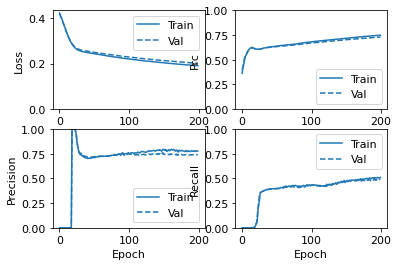

In [18]:
plot_metrics(baseline_history)

In [19]:
train_predictions_baseline = NN_model.predict(X_norm_32_train, batch_size=model.BATCH_SIZE)
test_predictions_baseline = NN_model.predict(X_norm_32_test, batch_size=model.BATCH_SIZE)

baseline_results = NN_model.evaluate(X_norm_32_test, Y_CATEGORICAL_test,
                                     batch_size=model.BATCH_SIZE, verbose=0)
for name, value in zip(NN_model.metrics_names, baseline_results):
    print(name, ': ', value)

loss :  0.20129360258579254
tp :  501.0
fp :  164.0
tn :  7042.0
fn :  484.0
Accuracy :  0.9208887815475464
Precision :  0.753383457660675
Recall :  0.5086294412612915
NPV :  0.9356896281242371
R score :  0.4858706295490265
MCC :  0.5786193609237671
FPR :  0.9772411584854126
auc :  0.9049697518348694
prc :  0.7369375824928284


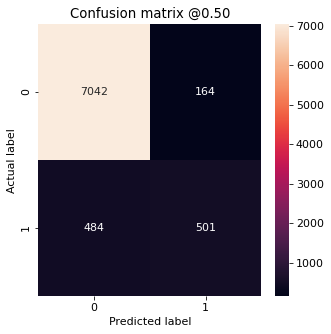

In [20]:
plot_cm(Y_CATEGORICAL_test, test_predictions_baseline)

#    WEIGHTED

In [21]:
weight_for_0 = (1 / (features.shape[0] - Y_CATEGORICAL.sum())) * (features.shape[0] / 2.0)
weight_for_1 = (1 / Y_CATEGORICAL.sum()) * (features.shape[0] / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.57
Weight for class 1: 4.21


In [22]:
weighted_model = make_NN_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_norm_32_train,
    Y_CATEGORICAL_train,
    batch_size=model.BATCH_SIZE,
    epochs=model.EPOCHS,
    validation_data=(X_norm_32_val, Y_CATEGORICAL_val),
    # The class weights go here
    class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/200
3/3 [==============================] - 3s 466ms/step - loss: 0.7923 - tp: 501.0000 - fp: 164.0000 - tn: 16879.0000 - fn: 1789.0000 - Accuracy: 0.8990 - Precision: 0.7534 - Recall: 0.2188 - NPV: 0.9042 - R score: 0.2092 - MCC: 0.3709 - FPR: 0.9904 - auc: 0.7990 - prc: 0.5287 - val_loss: 0.4321 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 4832.0000 - val_fn: 656.0000 - val_Accuracy: 0.8805 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_NPV: 0.8805 - val_R score: 0.0000e+00 - val_MCC: nan - val_FPR: 1.0000 - val_auc: 0.7527 - val_prc: 0.5190
Epoch 2/200
3/3 [==============================] - 0s 41ms/step - loss: 0.7784 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 9837.0000 - fn: 1305.0000 - Accuracy: 0.8829 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - NPV: 0.8829 - R score: 0.0000e+00 - MCC: nan - FPR: 1.0000 - auc: 0.7678 - 

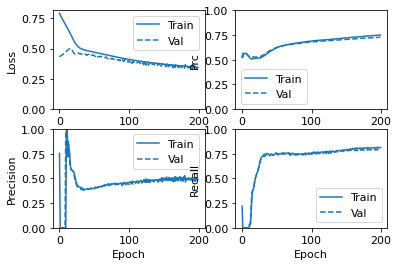

In [23]:
plot_metrics(weighted_history)


In [24]:
train_predictions_weighted = weighted_model.predict(X_norm_32_train, batch_size=model.BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_norm_32_test, batch_size=model.BATCH_SIZE)

loss :  0.3496987223625183
tp :  803.0
fp :  858.0
tn :  6348.0
fn :  182.0
Accuracy :  0.8730313777923584
Precision :  0.4834437072277069
Recall :  0.8152284026145935
NPV :  0.9721286296844482
R score :  0.6961609721183777
MCC :  0.5631622076034546
FPR :  0.8809325695037842
auc :  0.9178603887557983
prc :  0.7386019825935364



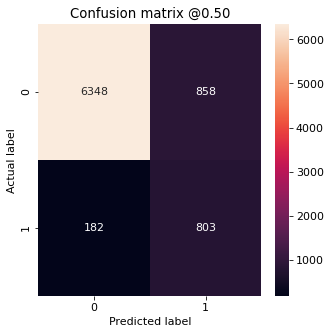

In [25]:
weighted_results = weighted_model.evaluate(X_norm_32_test, Y_CATEGORICAL_test,
                                           batch_size=model.BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(Y_CATEGORICAL_test, test_predictions_weighted)

In [26]:
pos_features = X_norm_32_train[Y_CATEGORICAL_train.T[0]]
neg_features = X_norm_32_train[~Y_CATEGORICAL_train.T[0]]

pos_labels = Y_CATEGORICAL_train[Y_CATEGORICAL_train.T[0]]
neg_labels = Y_CATEGORICAL_train[~Y_CATEGORICAL_train.T[0]]

In [27]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape


(9837, 23)

In [28]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(19674, 23)

In [29]:
BUFFER_SIZE = 100000


def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))  #.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds


pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [30]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 [3.71615201e-01 2.61363626e-01 1.50000006e-01 2.46948539e-03
 3.71615201e-01 6.57458961e-01 5.06890953e-01 3.35121870e-01
 4.89611626e-01 3.40465188e-01 1.22573644e-01 2.39294618e-01
 2.88272768e-01 1.98288381e-01 5.62332511e-01 1.89931616e-01
 4.01139855e-01 2.28232995e-01 2.55283403e-12 5.12667654e-13
 6.12220466e-02 4.78017807e-01 1.50000006e-01]

Label:  [ True]


In [31]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(model.BATCH_SIZE).prefetch(2)


In [32]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.505615234375


In [33]:
resampled_steps_per_epoch = np.ceil(2.0 * neg / model.BATCH_SIZE)
resampled_steps_per_epoch

11.0

In [34]:
resampled_model = make_NN_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((X_norm_32_val, Y_CATEGORICAL_val)).cache()
val_ds = val_ds.batch(model.BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=model.EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    validation_data=val_ds)

Epoch 1/200
11/11 [==============================] - 4s 201ms/step - loss: 0.6732 - tp: 8941.0000 - fp: 1366.0000 - tn: 28543.0000 - fn: 14397.0000 - Accuracy: 0.7040 - Precision: 0.8675 - Recall: 0.3831 - NPV: 0.6647 - R score: 0.3374 - MCC: 0.4238 - FPR: 0.9543 - auc: 0.8082 - prc: 0.7400 - val_loss: 0.6484 - val_tp: 332.0000 - val_fp: 251.0000 - val_tn: 4581.0000 - val_fn: 324.0000 - val_Accuracy: 0.8952 - val_Precision: 0.5695 - val_Recall: 0.5061 - val_NPV: 0.9339 - val_R score: 0.4542 - val_MCC: 0.4781 - val_FPR: 0.9481 - val_auc: 0.8320 - val_prc: 0.6089

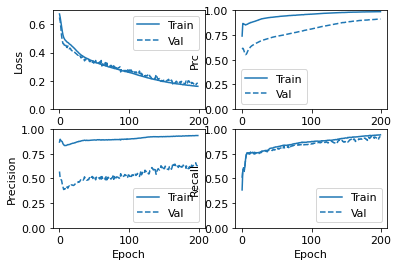

In [35]:
plot_metrics(resampled_history)

loss :  0.180167
tp :  898
fp :  528
tn :  6678
fn :  87
Accuracy :  0.924918
Precision :  0.629734
Recall :  0.911675
NPV :  0.98714
R score :  0.838403
MCC :  0.719158
FPR :  0.926728
auc :  0.976313
prc :  0.907027



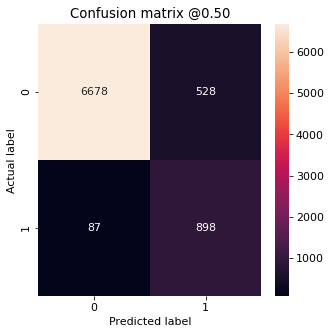

In [36]:
train_predictions_resampled = resampled_model.predict(X_norm_32_train, batch_size=model.BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(X_norm_32_test, batch_size=model.BATCH_SIZE)

resampled_results = resampled_model.evaluate(X_norm_32_test, Y_CATEGORICAL_test,
                                             batch_size=model.BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', '%.6g' % value)
print()

plot_cm(Y_CATEGORICAL_test, test_predictions_resampled)

3.9
loss :  0.198021
tp :  867
fp :  436
tn :  6770
fn :  118
Accuracy :  0.932365
Precision :  0.665388
Recall :  0.880203
NPV :  0.982869
R score :  0.819698
MCC :  0.728954
FPR :  0.939495
auc :  0.970255
prc :  0.871329

3.8
loss :  0.180167
tp :  898
fp :  528
tn :  6678
fn :  87h
Accuracy :  0.924918
Precision :  0.629734
Recall :  0.911675
NPV :  0.98714
R score :  0.838403
MCC :  0.719158
FPR :  0.926728
auc :  0.976313
prc :  0.907027
